In [2]:
import json
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import bootstrap
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.style.use("ggplot")

def load_file(fname, cache={}):
    if fname in cache:
        return cache[fname]
    with open(fname, "r") as f:
        cache[fname] = json.load(f)
    return cache[fname]

FSRS-4.5
Num files: 19993
DASH
Num files: 19990
FSRSv4
Num files: 19993
FSRSv3
Num files: 19993
GRU
Num files: 19990
FSRS-4.5-dry-run
Num files: 19993


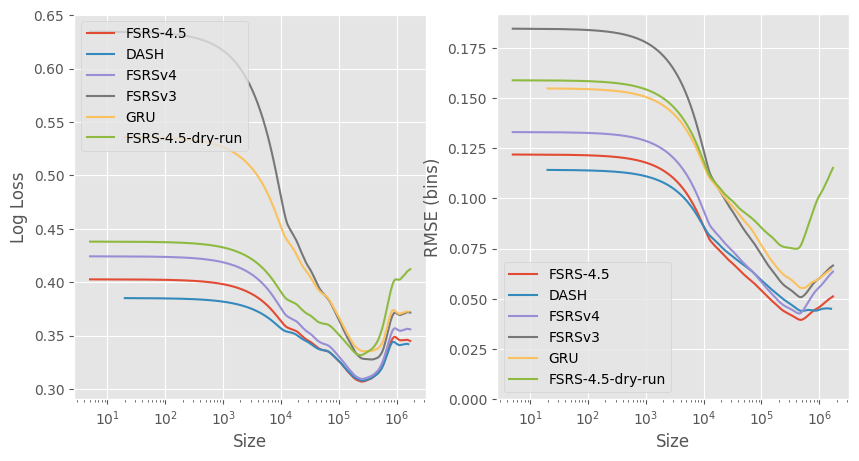

In [3]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for model in ["FSRS-4.5", "DASH", "FSRSv4", "FSRSv3", "GRU", "FSRS-4.5-dry-run"]:
    print(model)
    metrics = []
    sizes = []
    users = []
    RMSE_list = []
    LogLoss_list = []
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = list(result_dir.glob("*.json"))
    print("Num files:", len(result_files))
    for result_file in result_files:
        result = load_file(result_file)
        sizes.append(result["size"])
        users.append(result["user"])
        metrics.append(result["metrics"])
        RMSE_list.append(result["metrics"]["RMSE(bins)"])
        LogLoss_list.append(result["metrics"]["LogLoss"])

    log_loss, size = zip(*sorted(zip(LogLoss_list, sizes), key=lambda x: x[1]))
    log_loss = lowess(
        log_loss, size, it=0, is_sorted=True, return_sorted=False
    )
    ax1.plot(size, log_loss, label=model)
    rmse_bins, size = zip(*sorted(zip(RMSE_list, sizes), key=lambda x: x[1]))
    rmse_bins = lowess(
        rmse_bins, size, it=0, is_sorted=True, return_sorted=False
    )
    
    ax2.plot(size, rmse_bins, label=model)

ax1.semilogx()
ax2.semilogx()
ax1.legend()
ax2.legend()
ax1.set_xlabel("Size")
ax1.set_ylabel("Log Loss")
ax2.set_xlabel("Size")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("RMSE (bins)")
plt.show()

FSRS-4.5-fullinfo
Num files: 239
FSRS-4.5-dry-run-fullinfo
Num files: 1376
FSRS-4.5-pretrain-fullinfo
Num files: 664


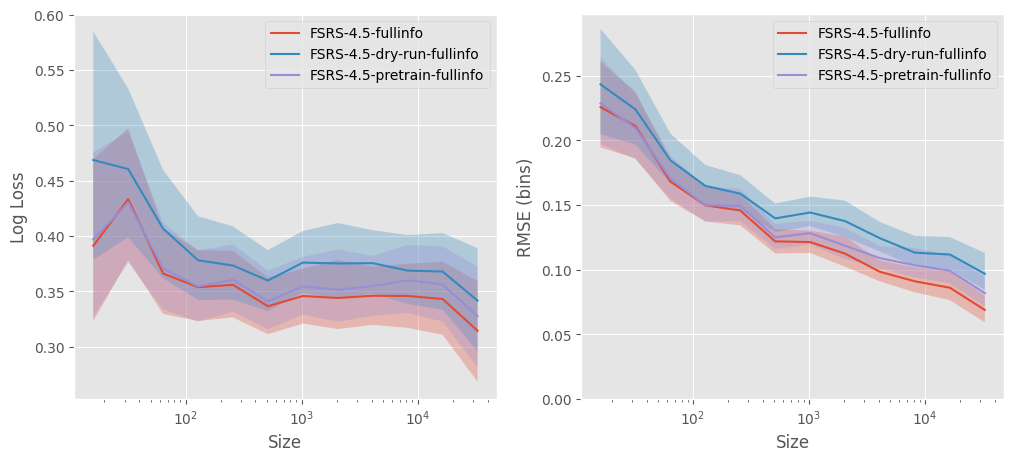

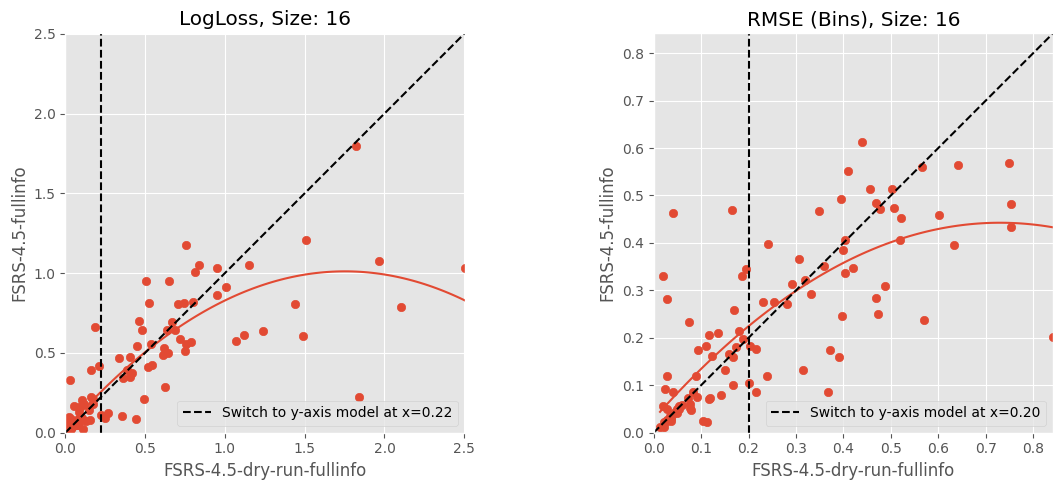

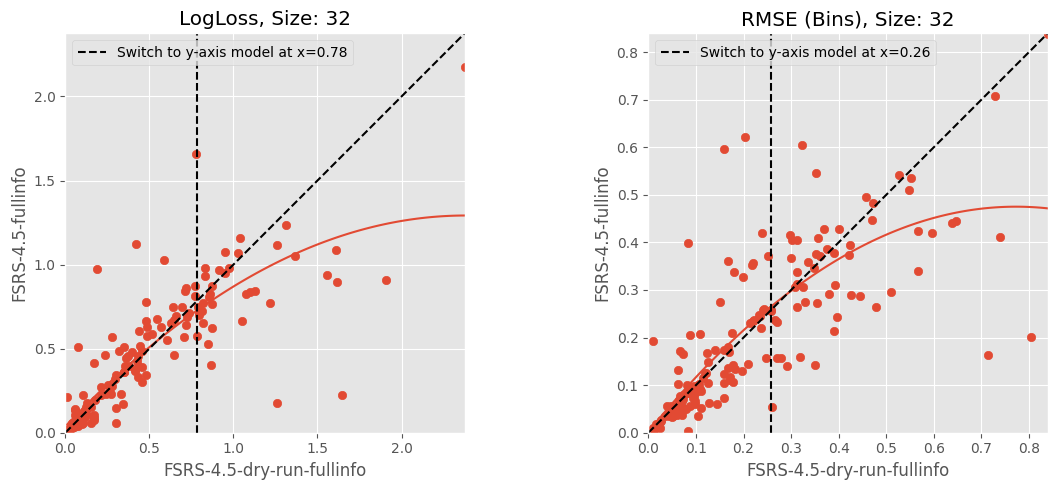

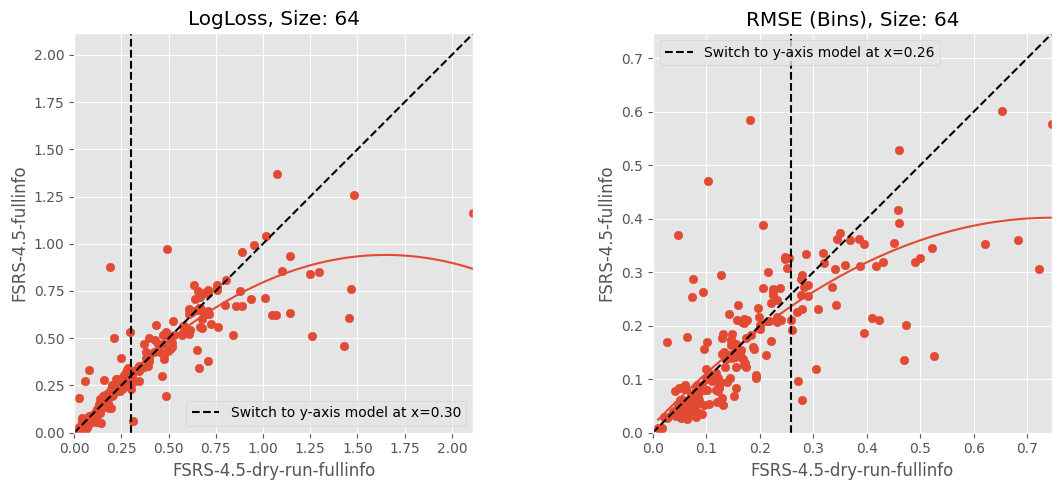

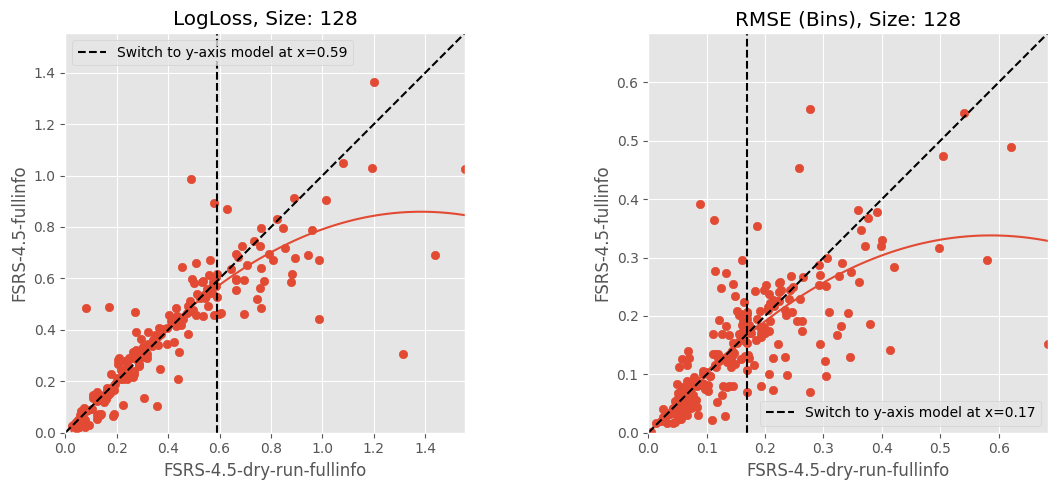

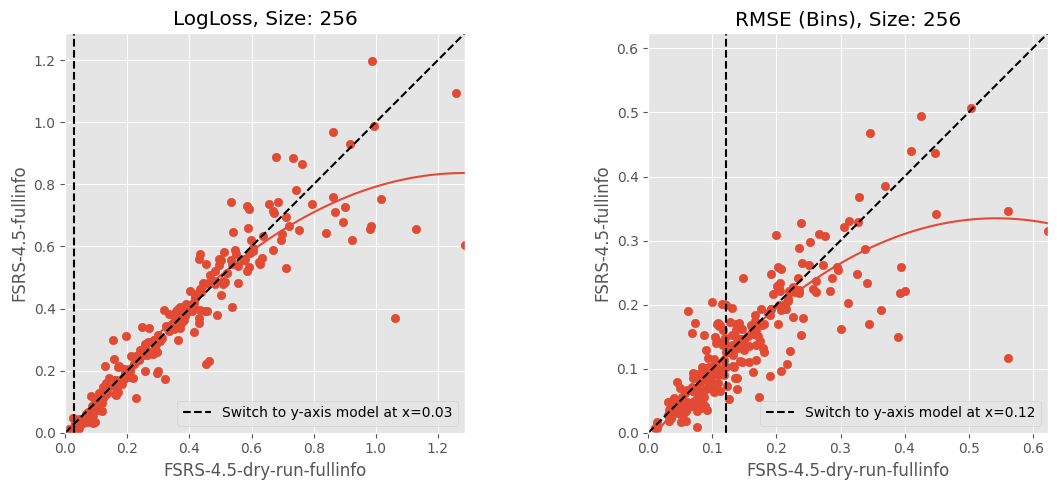

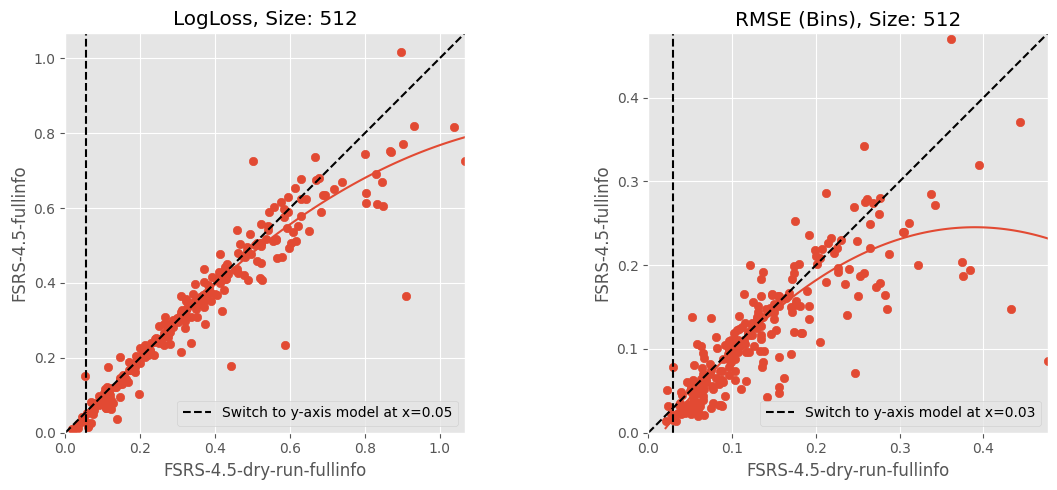

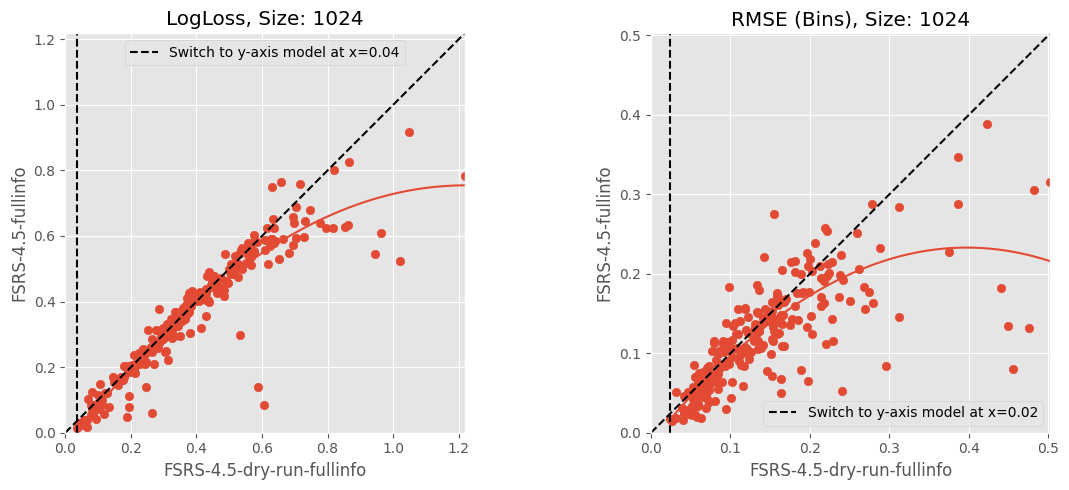

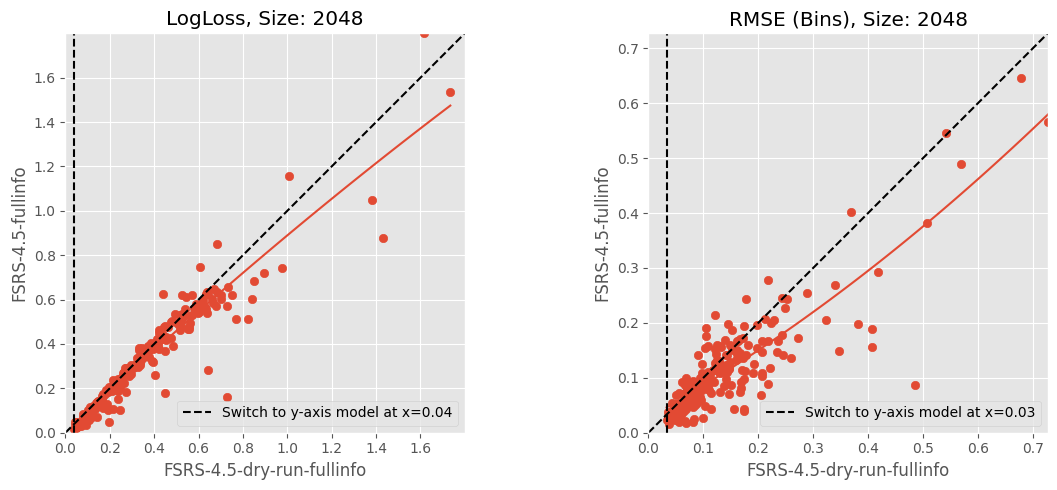

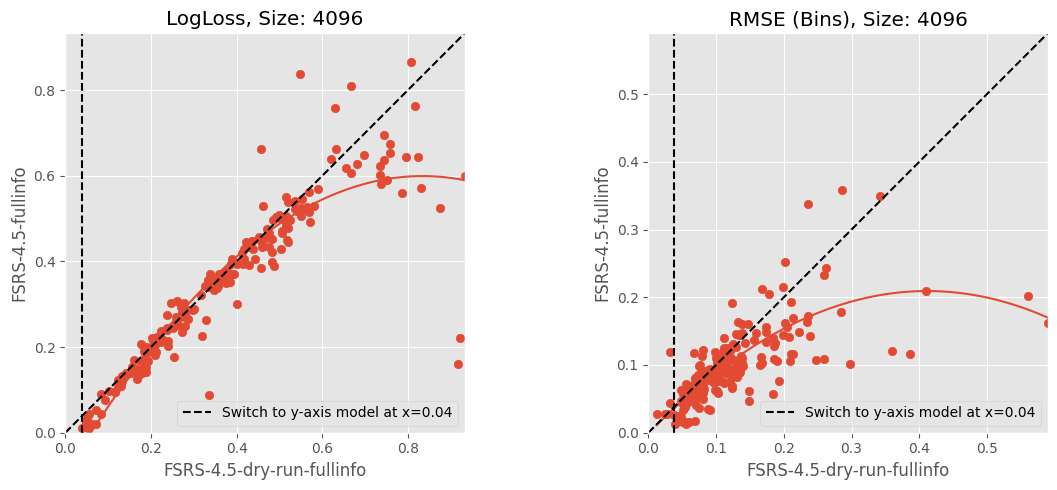

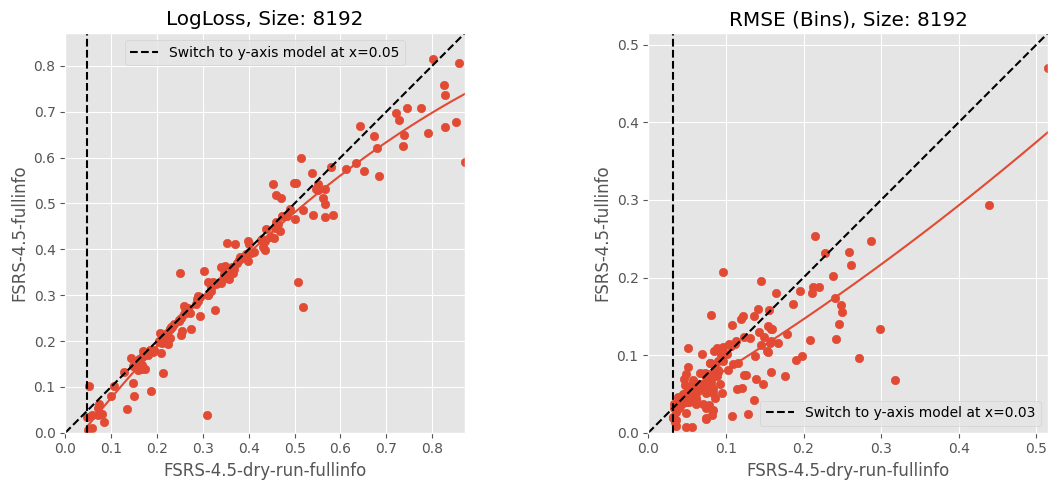

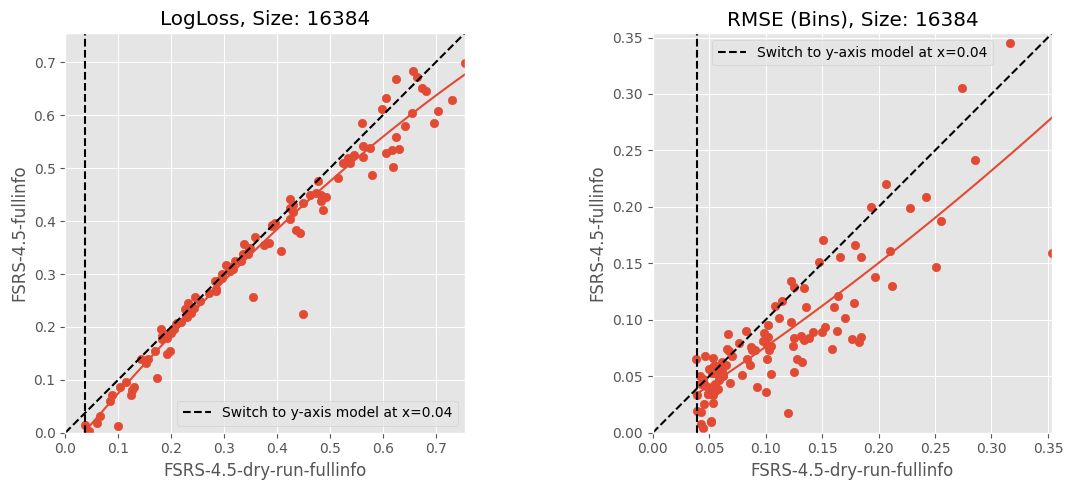

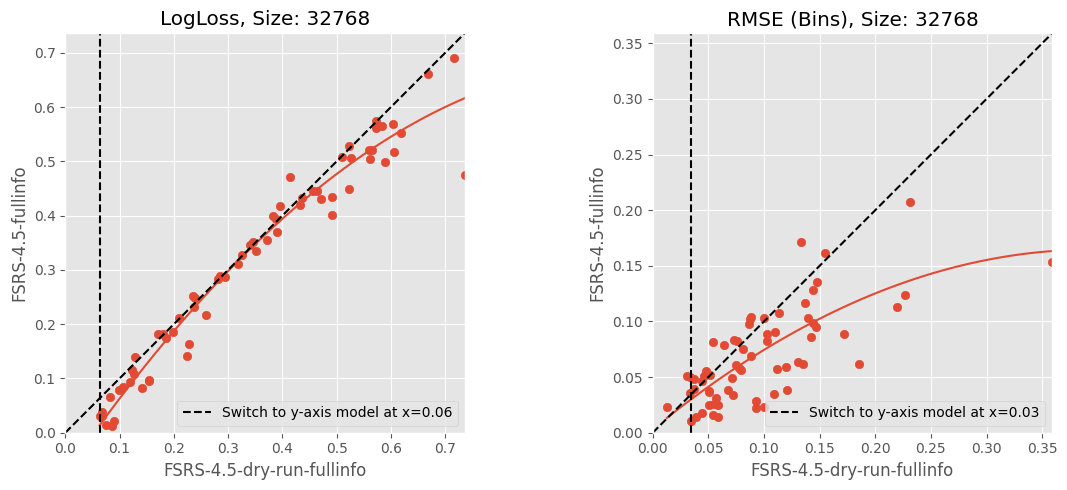

In [145]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Get sizes where training worked for each file
sizes_train_worked_for_dict = {}
unique_sizes = set()
models = ["FSRS-4.5-fullinfo", "FSRS-4.5-dry-run-fullinfo", "FSRS-4.5-pretrain-fullinfo"]
for model in models:
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = list(result_dir.glob("*.json"))
    for result_file in result_files:
        filename = result_file.name
        result = load_file(result_file)
        sizes = result["metrics"]["TrainSizes"]
        for s in sizes:
            if s not in unique_sizes:
                unique_sizes.add(s)
            k = (filename, s)
            if k not in sizes_train_worked_for_dict:
                sizes_train_worked_for_dict[k] = 0
            sizes_train_worked_for_dict[k] += 1
sizes_train_worked_for = {k for k,s in sizes_train_worked_for_dict.items() if s == len(models)}
unique_sizes = sorted(list(unique_sizes))

# Plot means & confidence intervals for each model
all_sizes = []
all_RMSE_list = []
all_LogLoss_list = []
models = ["FSRS-4.5-fullinfo", "FSRS-4.5-dry-run-fullinfo", "FSRS-4.5-pretrain-fullinfo"]
for model in models:
    print(model)
    sizes = []
    RMSE_list = []
    LogLoss_list = []
    result_dir = pathlib.Path(f"../result/{model}")
    result_files = list(result_dir.glob("*.json"))
    print("Num files:", len(result_files))
    if len(result_files) == 0:
        continue

    for result_file in result_files:
        filename = result_file.name
        result = load_file(result_file)
        this_sizes, this_RMSE_list, this_LogLoss_list = result["metrics"]["TrainSizes"], result["metrics"]["RMSE(bins)"], result["metrics"]["LogLoss"]
        i_to_keep = []
        for i,s in enumerate(this_sizes):
            if (filename, s) in sizes_train_worked_for:
                i_to_keep.append(i)
        sizes.extend([this_sizes[i] for i in i_to_keep])
        RMSE_list.extend([this_RMSE_list[i] for i in i_to_keep])
        LogLoss_list.extend([this_LogLoss_list[i] for i in i_to_keep])
    
    all_sizes.append(sizes)
    all_RMSE_list.append(RMSE_list)
    all_LogLoss_list.append(LogLoss_list)

    for this_losses, ax in zip([LogLoss_list, RMSE_list], [ax1, ax2]):
        # Get loss bins for each number of reviews known (called size)
        log_loss, size = zip(*sorted(zip(this_losses, sizes), key=lambda x: x[1]))
        log_loss = np.array(log_loss)
        size = np.array(size)
        size_unique = np.unique(size)
        log_loss_bins = [log_loss[size == s] for s in size_unique]

        # Remove any bins with less than 50 samples
        size_unique = [s for s, l in zip(size_unique, log_loss_bins) if len(l) >= 50]
        log_loss_bins = [l for l in log_loss_bins if len(l) >= 50]

        # Calculate 95% CI for each bin
        log_loss_bins_ci = [bootstrap((l,), np.mean, confidence_level=0.95, method="BCa").confidence_interval for l in log_loss_bins]

        # Plot means
        log_loss_means = [np.mean(l) for l in log_loss_bins]
        if len(size_unique) == 0: continue
        ax.plot(size_unique, log_loss_means, label=model)

        # Shade between confidence intervals
        log_loss_low = [l[0] for l in log_loss_bins_ci]
        log_loss_high = [l[1] for l in log_loss_bins_ci]
        ax.fill_between(size_unique, log_loss_low, log_loss_high, alpha=0.3)  #type: ignore

ax1.semilogx()
ax2.semilogx()
ax1.legend()
ax2.legend()
ax1.set_xlabel("Size")
ax1.set_ylabel("Log Loss")
ax2.set_xlabel("Size")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("RMSE (bins)")
plt.show()

# Plot all_RMSE_list[0] against all_RMSE_list[1] for each size (each size is a new graph)
model_x_index = 1  # Will find v where, after x=v, model_y does better than model_x
model_y_index = 0
for size in unique_sizes:
    RMSE_list_x = [x for x,s in zip(all_RMSE_list[model_x_index], all_sizes[model_x_index]) if s == size]
    RMSE_list_y = [y for y,s in zip(all_RMSE_list[model_y_index], all_sizes[model_y_index]) if s == size]
    LogLoss_list_x = [x for x,s in zip(all_LogLoss_list[model_x_index], all_sizes[model_x_index]) if s == size]
    LogLoss_list_y = [y for y,s in zip(all_LogLoss_list[model_y_index], all_sizes[model_y_index]) if s == size]

    # Must be at least 50 samples for each model
    if len(RMSE_list_x) < 50 or len(RMSE_list_y) < 50:
        continue
    num_pts = min(len(RMSE_list_x), len(RMSE_list_y))
    RMSE_list_x = RMSE_list_x[:num_pts]
    RMSE_list_y = RMSE_list_y[:num_pts]
    LogLoss_list_x = LogLoss_list_x[:num_pts]
    LogLoss_list_y = LogLoss_list_y[:num_pts]

    # Sort by x
    RMSE_list_x, RMSE_list_y = zip(*sorted(zip(RMSE_list_x, RMSE_list_y), key=lambda x: x[0]))
    LogLoss_list_x, LogLoss_list_y = zip(*sorted(zip(LogLoss_list_x, LogLoss_list_y), key=lambda x: x[0]))

    # Scatter plot
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(LogLoss_list_x, LogLoss_list_y)
    ax2.scatter(RMSE_list_x, RMSE_list_y)

    # Draw best fit line
    # # LogLoss
    # x = np.array(LogLoss_list_x)
    # y = np.array(LogLoss_list_y)
    # p = np.polyfit(x, y, 2)
    # x_fit = np.linspace(min(x), max(x), 100)
    # y_fit = np.polyval(p, x_fit)
    # ax1.plot(x_fit, y_fit)
    # # RMSE
    # x = np.array(RMSE_list_x)
    # y = np.array(RMSE_list_y)
    # p = np.polyfit(x, y, 2)
    # x_fit = np.linspace(min(x), max(x), 100)
    # y_fit = np.polyval(p, x_fit)
    # ax2.plot(x_fit, y_fit)

    # For v in [0, 0.1, 0.2, 0.3, ..., max_loss], get the points with v < x < v+0.1 and plot the point of the mean x and y
    # all_x_rmse, all_y_rmse, all_x_rmse_ci, all_y_rmse_ci = [], [], [], []
    # all_x_logloss, all_y_logloss, all_x_logloss_ci, all_y_logloss_ci = [], [], [], []
    # # for v in np.arange(0, max(RMSE_list_x), 0.1):
    # #     i_list_log_loss = [i for i in range(len(LogLoss_list_x)) if v <= LogLoss_list_x[i] < v + 0.1]
    # #     i_list_rmse = [i for i in range(len(RMSE_list_x)) if v <= RMSE_list_x[i] < v + 0.1]
    # for i_low in range(0, len(RMSE_list_x)-5, 5):
    #     i_list_log_loss = [i for i in range(i_low, i_low+5)]
    #     i_list_rmse = [i for i in range(i_low, i_low+5)]
    #     if len(i_list_log_loss) >= 5:
    #         all_x_logloss.append(np.mean([LogLoss_list_x[i] for i in i_list_log_loss]))
    #         all_y_logloss.append(np.mean([LogLoss_list_y[i] for i in i_list_log_loss]))
    #         # Get confidence intervals
    #         log_loss_ci_x = bootstrap(([LogLoss_list_x[i] for i in i_list_log_loss],), np.mean, confidence_level=0.95, method="BCa").confidence_interval
    #         log_loss_ci_y = bootstrap(([LogLoss_list_y[i] for i in i_list_log_loss],), np.mean, confidence_level=0.95, method="BCa").confidence_interval
    #         # Draw ellipse on graph between log_loss_ci_x.low, log_loss_ci_y.low and log_loss_ci_x.high, log_loss_ci_y.high
    #         ax1.add_patch(Ellipse((all_x_logloss[-1], all_y_logloss[-1]), log_loss_ci_x.high - log_loss_ci_x.low, log_loss_ci_y.high - log_loss_ci_y.low, edgecolor="black", facecolor="none"))
    #     if len(i_list_rmse) >= 5:
    #         all_x_rmse.append(np.mean([RMSE_list_x[i] for i in i_list_rmse]))
    #         all_y_rmse.append(np.mean([RMSE_list_y[i] for i in i_list_rmse]))
    #         # Get confidence intervals
    #         rmse_ci_x = bootstrap(([RMSE_list_x[i] for i in i_list_rmse],), np.mean, confidence_level=0.95, method="BCa").confidence_interval
    #         rmse_ci_y = bootstrap(([RMSE_list_y[i] for i in i_list_rmse],), np.mean, confidence_level=0.95, method="BCa").confidence_interval
    #         # Draw ellipse on graph between rmse_ci_x.low, rmse_ci_y.low and rmse_ci_x.high, rmse_ci_y.high
    #         ax2.add_patch(Ellipse((all_x_rmse[-1], all_y_rmse[-1]), rmse_ci_x.high - rmse_ci_x.low, rmse_ci_y.high - rmse_ci_y.low, edgecolor="black", facecolor="none"))
    # ax1.plot(all_x_logloss, all_y_logloss, "r")
    # ax2.plot(all_x_rmse, all_y_rmse, "r")

    # For each x point, get the y points after that and plot (x, mean y) and the confidence interval of y
    all_v_logloss, all_y_logloss, all_y_logloss_ci_low, all_y_logloss_ci_high = [], [], [], []
    all_v_rmse, all_y_rmse, all_y_rmse_ci_low, all_y_rmse_ci_high = [], [], [], []
    for i in range(len(LogLoss_list_x)):
        v = LogLoss_list_x[i]
        losses_before = LogLoss_list_x[:i]
        losses_after = LogLoss_list_y[i:]
        losses = losses_before + losses_after
        if len(losses_after) >= 5:
            all_v_logloss.append(v)
            all_y_logloss.append(np.mean(losses))
            # Get confidence intervals
            # logloss_ci = bootstrap((losses,), np.mean, confidence_level=0.95, method="BCa").confidence_interval
            # all_y_logloss_ci_low.append(logloss_ci.low)
            # all_y_logloss_ci_high.append(logloss_ci.high)
    for i in range(len(RMSE_list_x)):
        v = RMSE_list_x[i]
        losses_before = RMSE_list_x[:i]
        losses_after = RMSE_list_y[i:]
        losses = losses_before + losses_after
        if len(losses_after) >= 5:
            all_v_rmse.append(v)
            all_y_rmse.append(np.mean(losses))
            # Get confidence intervals
            # rmse_ci = bootstrap((losses,), np.mean, confidence_level=0.95, method="BCa").confidence_interval
            # all_y_rmse_ci_low.append(rmse_ci.low)
            # all_y_rmse_ci_high.append(rmse_ci.high)
    # ax1.plot(all_v_logloss, all_y_logloss, "r")
    # ax2.plot(all_v_rmse, all_y_rmse, "r")
    # # Shade between confidence intervals
    # ax1.fill_between(all_v_logloss, all_y_logloss_ci_low, all_y_logloss_ci_high, alpha=0.3)  #type: ignore
    # ax2.fill_between(all_v_rmse, all_y_rmse_ci_low, all_y_rmse_ci_high, alpha=0.3)  #type: ignore

    # Get the best v (at minimum y)
    best_v_logloss = all_v_logloss[np.argmin(all_y_logloss)]
    best_v_rmse = all_v_rmse[np.argmin(all_y_rmse)]

    # Draw dotted black vertical line at best v
    ax1.axvline(best_v_logloss, color="black", linestyle="--", label=f"Switch to y-axis model at x={best_v_logloss:.2f}")
    ax2.axvline(best_v_rmse, color="black", linestyle="--", label=f"Switch to y-axis model at x={best_v_rmse:.2f}")

    # Draw dotted line for x=y
    max_log_loss = max(max(LogLoss_list_x), max(LogLoss_list_y))
    max_rmse_loss = max(max(RMSE_list_x), max(RMSE_list_y))
    ax1.plot([0, max_log_loss], [0, max_log_loss], "k--")
    ax2.plot([0, max_rmse_loss], [0, max_rmse_loss], "k--")

    # Format and display
    ax1.set_title(f"LogLoss, Size: {size}")
    ax2.set_title(f"RMSE (Bins), Size: {size}")
    ax1.set_xlabel(models[model_x_index])
    ax1.set_ylabel(models[model_y_index])
    ax2.set_xlabel(models[model_x_index])
    ax2.set_ylabel(models[model_y_index])
    ax1.set_xlim(0, max_log_loss)
    ax1.set_ylim(0, max_log_loss)
    ax2.set_xlim(0, max_rmse_loss)
    ax2.set_ylim(0, max_rmse_loss)
    # Ensure aspect ratio is 1:1
    ax1.set_aspect("equal", adjustable="box")
    ax2.set_aspect("equal", adjustable="box")
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()
